In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
import rasterio as rio
import functions as f
import xarray as xr
from importlib import reload

In [3]:
#open the GTiff file with rasterio

pop_day_as = rio.open(r'data_day_30ss\ENACT_POP_D072011_EU28_R2020A_4326_30ss_V1_0.tif')
pop_night_as = rio.open(r'data_night_30ss\ENACT_POP_N072011_EU28_R2020A_4326_30ss_V1_0.tif')

#open the nc file with xarray
ds_temp = xr.open_dataset(r'dataset-sis-urban-climate-cities-cdfdd1be-d564-4618-8163-223dfaf3c793\tas_Nantes_UrbClim_2011_07_v1.0.nc')
ds_rh = xr.open_dataset(r'dataset-sis-urban-climate-cities-333884ee-f1f6-4064-8d65-6d3b868ca96b\russ_Nantes_UrbClim_2011_07_v1.0.nc')
rural_urban_mask = xr.open_dataset(r'dataset-sis-urban-climate-cities-6eb67d3e-8568-4a30-b2c3-e13ea5485ee8\ruralurbanmask_Nantes_UrbClim_v1.0.nc')


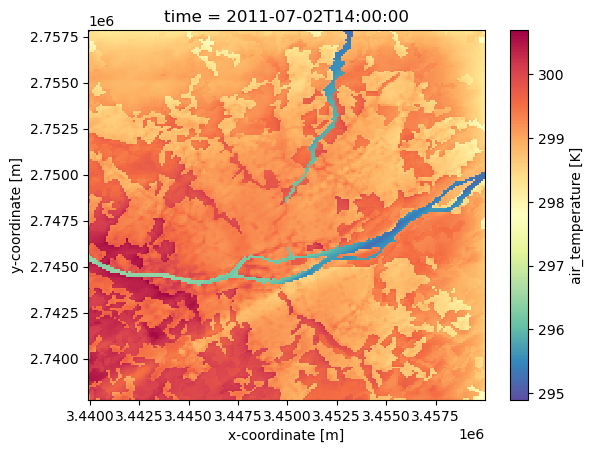

In [4]:
#plot the tas variable a tim 0 over the whole spatial area
ds_temp.tas[38,:,:].plot(cmap='Spectral_r')


In [5]:
#Crop and downsample the population data and temperature data

pop_day_nts, pop_night_nts, down_ds_temp = f.crop_and_downgrade(pop_day_as,pop_night_as, ds_temp)
pop_day_nts, pop_night_nts, down_ds_rh = f.crop_and_downgrade(pop_day_as,pop_night_as, ds_rh)
pop_day_nts, pop_night_nts, down_ds_mask = f.crop_and_downgrade(pop_day_as,pop_night_as, rural_urban_mask)

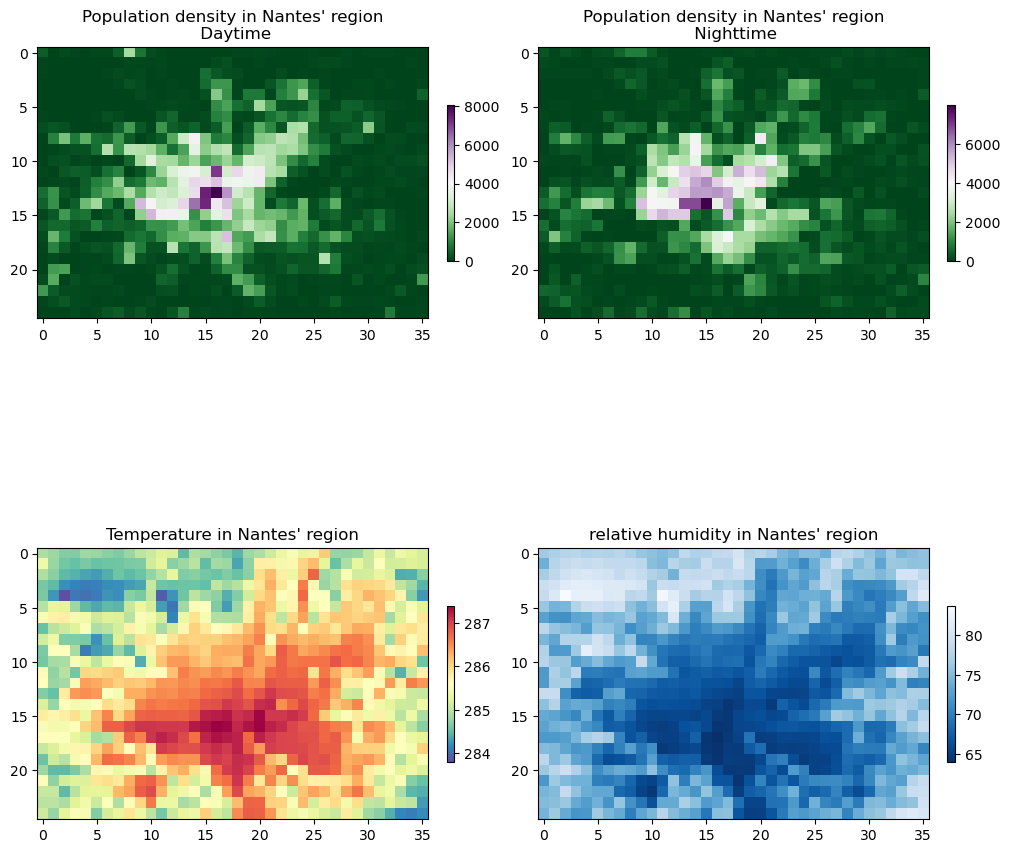

In [6]:
fig, axs = plt.subplots(2,2, figsize=(10,10), constrained_layout=True)

img1 = axs[0,0].imshow(pop_day_nts, cmap='PRGn_r')
axs[0,0].set_title('Population density in Nantes\' region\n Daytime')
cbar1 = fig.colorbar(img1, ax=axs[0, 0], orientation='vertical', fraction=0.02, pad=0.04)

img2 = axs[0,1].imshow(pop_night_nts, cmap='PRGn_r')
axs[0,1].set_title('Population density in Nantes\' region\n Nighttime')
cbar2 = fig.colorbar(img2, ax=axs[0, 1], orientation='vertical', fraction=0.02, pad=0.04)

img3 = axs[1,0].imshow(down_ds_temp.tas[0,:,:36], cmap='Spectral_r')
axs[1,0].set_title('Temperature in Nantes\' region')
cbar3 = fig.colorbar(img3, ax=axs[1, 0], orientation='vertical', fraction=0.02, pad=0.04)

img4 = axs[1,1].imshow(down_ds_rh.russ[0,:,:36], cmap='Blues_r')
axs[1,1].set_title('relative humidity in Nantes\' region')
cbar4 = fig.colorbar(img4, ax=axs[1, 1], orientation='vertical', fraction=0.02, pad=0.04)

plt.show()



## Desired data format

We are looking for a serie of urban areas with population,humidity, wind speed. the idea is to predict the delta of temperature with rural areas. Lets build a dataset with the following format:
[urban_area_id, population, humidity, wind_speed, delta_temperature]

In [7]:
populations = np.concatenate([np.tile(pop_night_nts.flatten(), 8), np.tile(pop_day_nts.flatten(), 12), np.tile(pop_night_nts.flatten(), 4)])
populations = np.tile(populations, 744//24)
populations.shape

(669600,)

In [8]:
averages = []
for i in range(744):
    rural_avg = down_ds_temp.tas[i,:,:36].where(down_ds_mask.ruralurbanmask[:,:36] == 1).mean(dim=['x','y']).values.item()
    averages.append(down_ds_temp.tas[i,:,:36].values - rural_avg)
averages = np.array(averages).flatten()

In [9]:
averages.shape

(669600,)

In [10]:
data_df = pd.DataFrame({'tas':down_ds_temp.tas[:,:,:36].values.flatten(), 
                        'relative_humidity':down_ds_rh.russ[:,:,:36].values.flatten(),
                        'pop':populations,
                        'temp_delta':averages}, index=range(0,down_ds_temp.tas[:,:,:36].values.flatten().shape[0]))


In [11]:
data_df

,tas,relative_humidity,pop,temp_delta
0,284.907959,76.593887,265.300118,-0.522522
1,284.815887,77.267090,51.123624,-0.614594
2,284.686646,77.917992,236.011818,-0.743835
3,284.666595,78.048599,112.933054,-0.763885
4,284.822357,77.441696,10.143447,-0.608124
...,...,...,...,...
669595,288.640564,88.149696,30.145422,-0.864563
669596,288.484070,88.550613,470.666956,-1.021057
669597,288.349854,89.096046,83.005399,-1.155273
669598,288.428894,88.610123,97.769220,-1.076233


In [12]:
#take a random subset of the data
data_df_sample = data_df.sample(frac=0.01)
data_df_sample

,tas,relative_humidity,pop,temp_delta
243969,289.726746,92.804550,60.030667,0.266144
382584,289.914978,63.991089,10.733145,-0.473328
1067,285.263123,77.814682,1526.611788,0.397034
50662,291.756866,46.372437,47.149047,-0.300262
149647,287.860718,83.358177,748.406583,0.678650
...,...,...,...,...
128419,288.376862,71.698685,14.186479,0.209534
183617,292.475922,61.941917,5.316317,0.006226
197425,286.203522,93.763557,136.255952,-0.001556
556953,296.236633,51.236103,11.799062,0.585571


In [13]:
'''reload(f)
#Construct a neural network to predict the temperature delta with sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

X = data_df_sample[['pop', 'relative_humidity']]
y = data_df_sample['temp_delta']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

f.mplReg(X_train, X_test, y_train, y_test)
'''


"reload(f)\n#Construct a neural network to predict the temperature delta with sklearn\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.neural_network import MLPRegressor\nfrom sklearn.metrics import mean_squared_error\nfrom sklearn.metrics import r2_score\n\nX = data_df_sample[['pop', 'relative_humidity']]\ny = data_df_sample['temp_delta']\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)\n\nf.mplReg(X_train, X_test, y_train, y_test)\n"

In [14]:
'''from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

def decision_tree(X_test, X_train, y_test, y_train):
    
    param_grid = {'max_depth': np.arange(1, 25)}
    tree = GridSearchCV(DecisionTreeRegressor(), param_grid, verbose=1)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    print('MSE: ', mean_squared_error(y_test, y_pred))
    print('R2: ', r2_score(y_test, y_pred))
    return tree

tree = decision_tree(X_test, X_train, y_test, y_train)'''

"from sklearn.tree import DecisionTreeRegressor\nfrom sklearn.model_selection import GridSearchCV\n\ndef decision_tree(X_test, X_train, y_test, y_train):\n    \n    param_grid = {'max_depth': np.arange(1, 25)}\n    tree = GridSearchCV(DecisionTreeRegressor(), param_grid, verbose=1)\n    tree.fit(X_train, y_train)\n    y_pred = tree.predict(X_test)\n    print('MSE: ', mean_squared_error(y_test, y_pred))\n    print('R2: ', r2_score(y_test, y_pred))\n    return tree\n\ntree = decision_tree(X_test, X_train, y_test, y_train)"

In [15]:
'''

#build a convolutional neural network with tensorflow
import tensorflow as tf
from tensorflow import keras

X = data_df_sample[['pop', 'relative_humidity']]
y = data_df_sample['temp_delta']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = np.array(X_train).reshape(-1,2,1)
X_test = np.array(X_test).reshape(-1,2,1)

model = keras.Sequential([
    keras.layers.Conv1D(64, 2, activation='relu', input_shape=(2,1)),
    keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='SAME'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.fit(X_train, y_train, epochs=5, batch_size=1)

model.evaluate(X_test, y_test)

y_pred = model.predict(X_test)
print('MSE: ', mean_squared_error(y_test, y_pred))
print('R2: ', r2_score(y_test, y_pred))'''

"\n\n#build a convolutional neural network with tensorflow\nimport tensorflow as tf\nfrom tensorflow import keras\n\nX = data_df_sample[['pop', 'relative_humidity']]\ny = data_df_sample['temp_delta']\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)\n\nX_train = np.array(X_train).reshape(-1,2,1)\nX_test = np.array(X_test).reshape(-1,2,1)\n\nmodel = keras.Sequential([\n    keras.layers.Conv1D(64, 2, activation='relu', input_shape=(2,1)),\n    keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='SAME'),\n    keras.layers.Flatten(),\n    keras.layers.Dense(64, activation='relu'),\n    keras.layers.Dense(1)\n])\n\nmodel.compile(optimizer='adam', loss='mse', metrics=['mae'])\n\nmodel.fit(X_train, y_train, epochs=5, batch_size=1)\n\nmodel.evaluate(X_test, y_test)\n\ny_pred = model.predict(X_test)\nprint('MSE: ', mean_squared_error(y_test, y_pred))\nprint('R2: ', r2_score(y_test, y_pred))"

In [21]:
#create a random forest regressor with sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

data_df_sample = data_df.sample(frac=0.1, random_state = 1)
X = data_df_sample[['pop', 'relative_humidity']]
y = data_df_sample['temp_delta']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rf = RandomForestRegressor(n_estimators=100, max_depth=10, verbose=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('R2: ', r2_score(y_test, y_pred))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   16.3s


MAE:  0.36240438244755335
R2:  0.2809309025247575


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
